In [13]:
from build.util.datetime import eta, clock

from array import array
from torch import Tensor
from numpy import ndarray
from matplotlib.pyplot import Axes
from ddpm import DDPMSampler
from PIL import Image

import torch
import numpy as np
import struct
import os
import random
import matplotlib.pyplot as plt
import math

In [14]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE = torch.float32
INCH_PER_PIXEL = 0.01


In [15]:
class MnistDataloader(object):
    def __init__(self, training_img_filepath: str, training_lbl_filepath: str, test_img_filepath: str,
                 test_lbl_filepath: str):
        self.training_images_filepath = training_img_filepath
        self.training_labels_filepath = training_lbl_filepath
        self.test_images_filepath = test_img_filepath
        self.test_labels_filepath = test_lbl_filepath

    @staticmethod
    def read_images_labels(images_filepath: str, labels_filepath: str):
        labels: list[int] = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())

        size = len(labels)
        images: list[ndarray] = []
        # for _ in range(size):
        #     images.append([0] * rows * cols)
        for x in range(size):
            img = np.array(image_data[x * rows * cols:(x + 1) * rows * cols], np.float16)
            img = img.reshape(28, 28)
            images.append(img)

        return images, labels

    def load_data(self):
        x_tr, y_tr = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_te, y_te = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_tr, y_tr), (x_te, y_te)

In [16]:
input_path = 'D:/Python Projects/diffusion/examples/mnist/data'
training_images_filepath = os.path.join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = os.path.join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = os.path.join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Load MNIST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath,
                                   test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [17]:
def get_classification_dataset(x_: list[ndarray], y_: list[int], lim: int = None, device='cpu', dtype=torch.float32):
    if lim is None:
        lim = len(x_)
    x = torch.cat([torch.tensor(arr, device=device, dtype=dtype).unsqueeze(0) for arr in x_[:lim]], 0)
    y = torch.tensor(y_[:lim], device=device, dtype=dtype)
    return x, y


def get_size(tensor: Tensor):
    return tensor.element_size() * tensor.numel()

In [18]:
SAMPLES = 10000
train_dataset = get_classification_dataset(x_train, y_train, SAMPLES, DEVICE)
get_size(train_dataset[0]) / (1024 ** 2)
test_dataset = get_classification_dataset(x_test, y_test, SAMPLES, DEVICE)
get_size(test_dataset[0]) / (1024 ** 2)
train_dataset[0].shape, train_dataset[1].shape

(torch.Size([10000, 28, 28]), torch.Size([10000]))

In [19]:
def check_crossover():
    ts = clock.perf_counter()
    units_total = test_dataset[0].shape[0]
    count = 0
    with torch.no_grad():
        for x, test_point in enumerate(test_dataset[0]):
            test_point = test_point.unsqueeze(0).expand(train_dataset[0].shape)
            if torch.any(torch.all(torch.all(test_point == train_dataset[0], -1), -1)):
                count += 1
            eta(ts, x + 1, units_total)
    return count


check_crossover()

: progress=100% eta=0sec

0

In [142]:
def show_tensor(tensor: Tensor, ax: Axes = None, title: str = None, cmap=plt.cm.gray):
    if isinstance(tensor, Tensor):
        tensor = tensor.detach().cpu().numpy()
    plotter = plt if ax is None else ax
    plotter.imshow(tensor, cmap=cmap)
    plotter.axis('off')
    if title is not None:
        if ax is None:
            plt.title(title, fontsize=15)
        else:
            plotter.set_title(title, fontsize=15)
    if ax is None:
        plt.show()

def show_random(height=1080, width=1440, cmap=plt.cm.gray):
    images_2_show = []
    titles_2_show = []
    for i in range(10):
        r = random.randint(0, len(x_train) - 1)
        images_2_show.append(x_train[r])
        titles_2_show.append(f"train [{r}] = {y_train[r]}")

    for i in range(0, 5):
        r = random.randint(1, 10000)
        images_2_show.append(x_test[r])
        titles_2_show.append(f"test [{r}] = {y_test[r]}")

    _, axes = plt.subplots(3, 5, figsize=(width * INCH_PER_PIXEL, height * INCH_PER_PIXEL))
    plt.figure(figsize=(30, 20))
    for ax, img, txt in zip(axes.flatten(), images_2_show, titles_2_show):
        show_tensor(img, ax, txt, cmap)
    plt.show()

def get_random_indices(tensor: Tensor, *limits: int):
    assert 0 < len(limits) <= tensor.ndim
    indices = [[np.random.randint(0, tensor.shape[dim_idx]) for _ in range(dim_size)] for dim_idx, dim_size in enumerate(limits)]
    return indices

In [143]:
get_random_indices(torch.randn(28, 28), 3, 3)

[[10, 17, 25], [25, 16, 18]]

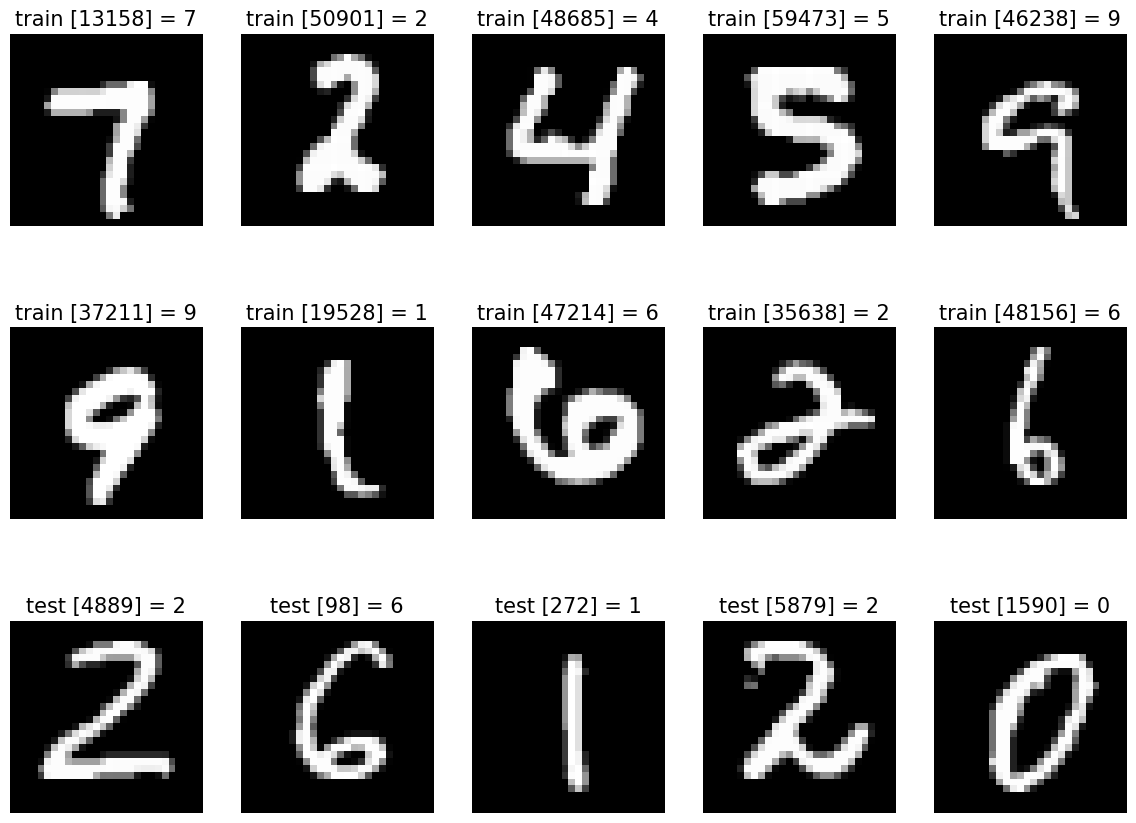

<Figure size 3000x2000 with 0 Axes>

In [144]:
show_random()

In [145]:
generator = torch.Generator()
generator.manual_seed(100)

ddpm_sampler = DDPMSampler(generator)
ddpm_sampler.alphas_cumprod.shape, ddpm_sampler.alphas_cumprod[:10]

(torch.Size([1000]),
 tensor([0.9991, 0.9983, 0.9974, 0.9966, 0.9957, 0.9948, 0.9940, 0.9931, 0.9922,
         0.9913]))

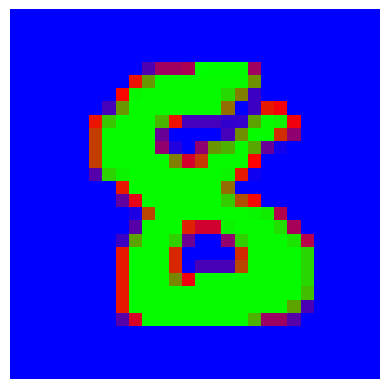

(None,)

In [146]:
# How many noise levels to generate
noise_levels = [0, 10, 50, 75, 100, 250, 500, 750]

test_img = random.choice(x_test)
test_img_tensor = torch.tensor(test_img) #  / 255
show_tensor(test_img_tensor, cmap=plt.cm.brg),

In [147]:
nl_array = np.array([0, 10, 50, 75, 100, 250, 500, 750])
nl_array / nl_array.sum()

array([0.        , 0.00576369, 0.02881844, 0.04322767, 0.05763689,
       0.14409222, 0.28818444, 0.43227666])

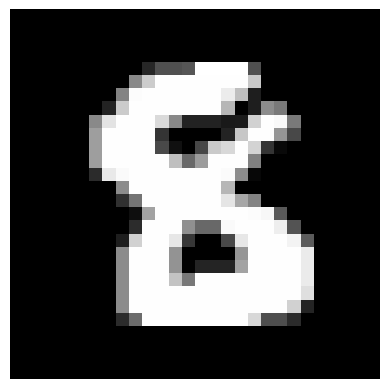

tensor([0.9904, 0.9547, 0.8917, 0.7916, 0.6474, 0.4634, 0.2710, 0.1163, 0.0320,
        0.0047])


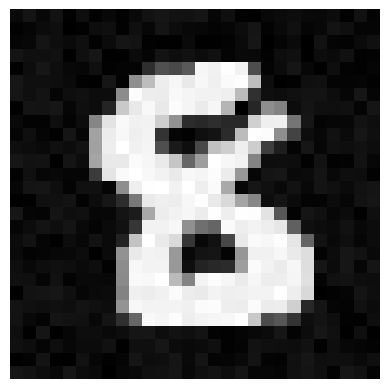

tensor([0.9904, 0.9547, 0.8917, 0.7916, 0.6474, 0.4634, 0.2710, 0.1163, 0.0320,
        0.0047])


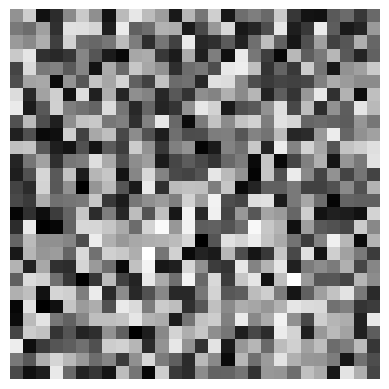

In [199]:
# Create a batch by repeating the same image many times
batch = test_img_tensor.unsqueeze(0).expand(len(noise_levels), *test_img_tensor.shape)

def get_noisy_image_(image: Tensor, t: int, alphas: Tensor = None, normalize=True):
    if alphas is None:
        crop   = 1
        offset = 0.0
        power  = 1
        points = ddpm_sampler.alphas_cumprod.shape[0]

        lim = max(abs(t)+1, 10)
        offset = round(points * offset)
        rg = torch.cumsum((torch.arange(lim) + 1) ** power, dim=0)
        print(torch.arange(lim) + 1)
        print(rg)
        print(((rg - rg.min()) / (rg.max() - rg.min())))
        print((ddpm_sampler.alphas_cumprod.shape[0] // 1 -1))
        print(((((rg - rg.min()) / (rg.max() - rg.min())) * (((points - offset) // crop) - 1)) + offset).to(torch.int32))
        rg = torch.round((((rg - rg.min()) / (rg.max() - rg.min())) * (((points - offset) // crop) - 1)) + offset).to(torch.int32)
        alphas = ddpm_sampler.alphas_cumprod[rg]
    print(alphas.shape, alphas)
    if normalize and torch.any(image > 1.0):
        image /= 255
    return np.sqrt(alphas[t]) * image + np.sqrt(1 - alphas[t]) * torch.rand_like(image)

def get_noisy_image(image: Tensor, t: int, alphas: Tensor = None, normalize=True):
    if alphas is None:
        points = ddpm_sampler.alphas_cumprod.shape[0]
        offset = 0.01
        offset = round(points * offset)
        lim = max(abs(t)+1, 10)
        rg = torch.cumsum(torch.arange(lim) + 1, dim=0)
        rg = torch.round((((rg - rg.min()) / (rg.max() - rg.min())) * ((points - offset) - 1)) + offset).to(torch.int32)
        alphas = ddpm_sampler.alphas_cumprod[rg]
    print(alphas)
    if normalize and torch.any(image > 1.0):
        image /= 255
    return np.sqrt(alphas[t]) * image + np.sqrt(1 - alphas[t]) * torch.rand_like(image)

show_tensor(test_img_tensor, cmap=plt.cm.grey)
show_tensor(get_noisy_image(test_img_tensor, 0), cmap=plt.cm.grey)
show_tensor(get_noisy_image(test_img_tensor, -1), cmap=plt.cm.grey)


tensor([0.9904, 0.9547, 0.8917, 0.7916, 0.6474, 0.4634, 0.2710, 0.1163, 0.0320,
        0.0047])
tensor([0.9904, 0.9547, 0.8917, 0.7916, 0.6474, 0.4634, 0.2710, 0.1163, 0.0320,
        0.0047])
tensor([0.9904, 0.9547, 0.8917, 0.7916, 0.6474, 0.4634, 0.2710, 0.1163, 0.0320,
        0.0047])
tensor([0.9904, 0.9547, 0.8917, 0.7916, 0.6474, 0.4634, 0.2710, 0.1163, 0.0320,
        0.0047])
tensor([0.9904, 0.9547, 0.8917, 0.7916, 0.6474, 0.4634, 0.2710, 0.1163, 0.0320,
        0.0047])
tensor([0.9904, 0.9547, 0.8917, 0.7916, 0.6474, 0.4634, 0.2710, 0.1163, 0.0320,
        0.0047])
tensor([0.9904, 0.9547, 0.8917, 0.7916, 0.6474, 0.4634, 0.2710, 0.1163, 0.0320,
        0.0047])
tensor([0.9904, 0.9547, 0.8917, 0.7916, 0.6474, 0.4634, 0.2710, 0.1163, 0.0320,
        0.0047])
tensor([0.9904, 0.9547, 0.8917, 0.7916, 0.6474, 0.4634, 0.2710, 0.1163, 0.0320,
        0.0047])
tensor([0.9904, 0.9547, 0.8917, 0.7916, 0.6474, 0.4634, 0.2710, 0.1163, 0.0320,
        0.0047])


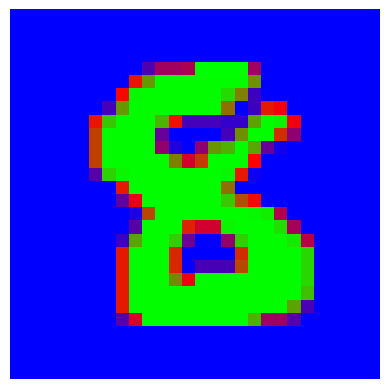

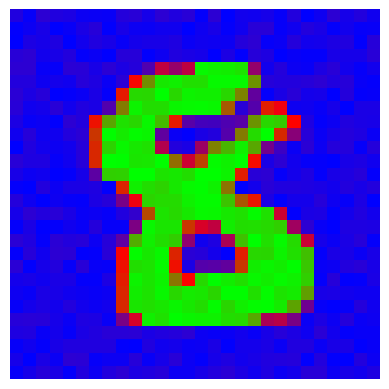

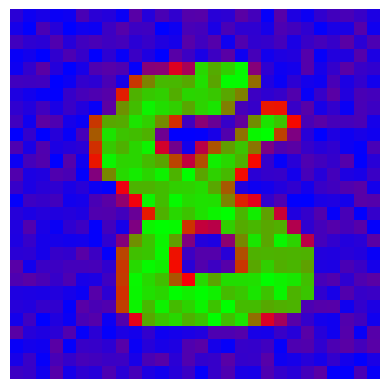

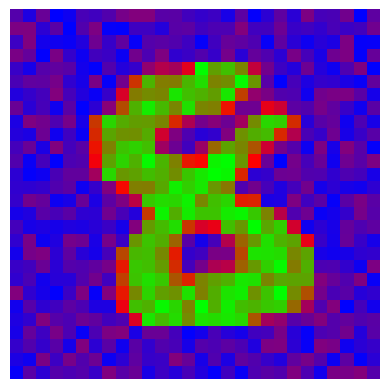

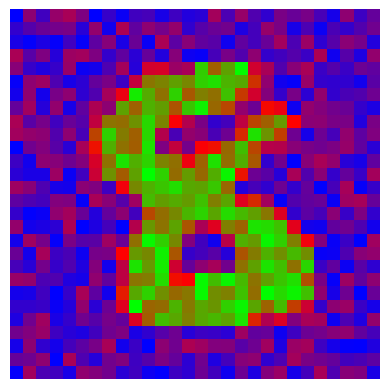

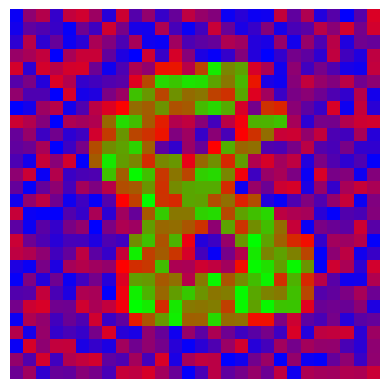

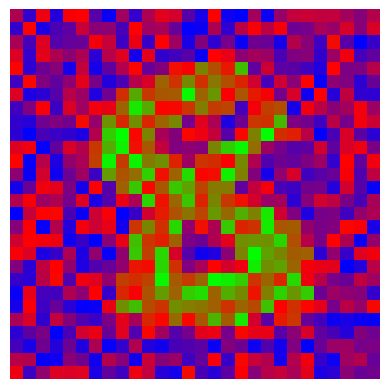

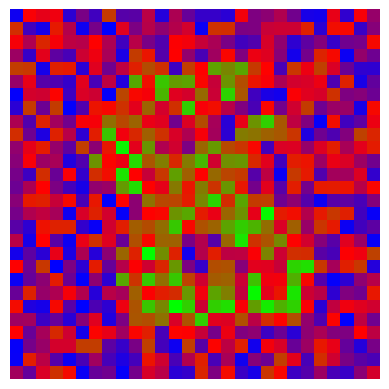

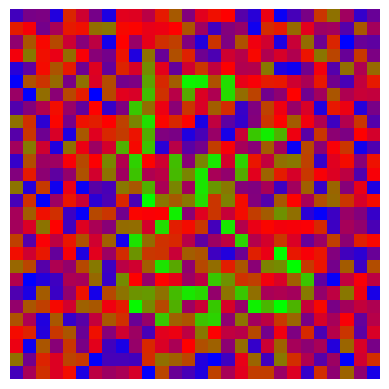

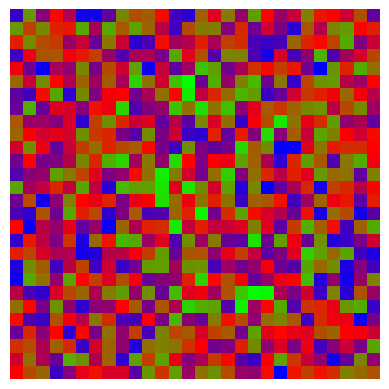

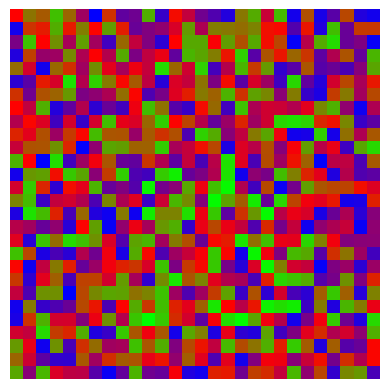

[None, None, None, None, None, None, None, None, None, None]

In [200]:
ts = torch.tensor(noise_levels, dtype=torch.int, device=batch.device)
noise_imgs = [get_noisy_image(test_img_tensor, i) for i in range(10)]
show_tensor(test_img_tensor, cmap=plt.cm.brg)
[show_tensor(noise_img, title=None, cmap=plt.cm.brg) for img_num, noise_img in enumerate(noise_imgs)]